# NLP and Sentiment Analysis based Trading Strategy

In this case study we use NLP to build a trading strategy combining some of the concepts that we went through in some of the previous chapters.



In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install nltk==3.4
    !pip install textblob==0.15.3
    !pip install -U SpaCy==2.2.0
    !python -m spacy download en_core_web_lg
    !pip install backtrader==1.9.74.123    

Let us load the libraries

In [2]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tatsa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Using TensorFlow backend.


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:    
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker 
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker 
        df_ticker_return = df_ticker_return.append(data_temp)
df_ticker_return.to_csv(r'Data\Step2.2_ReturnData.csv')

Let us see the content of the json file

In [5]:
z = zipfile.ZipFile("Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample

'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [6]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [7]:
jsonParser(json.loads(fileData))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

In [8]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Data/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

Let us look at the content of the data

In [9]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(2)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return.

In [10]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [11]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [12]:
data_df.head(2)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88


In [13]:
data_df.dropna().to_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|', index=False)

In [14]:
data_df = pd.read_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [16]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [17]:
TextBlob(text1).sentiment.polarity

0.5

In [18]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

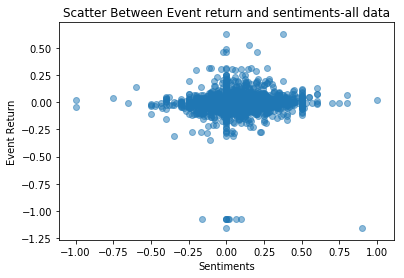

In [19]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [20]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.042749340813834254


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

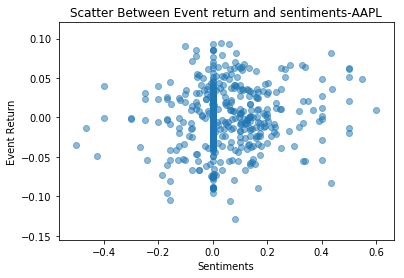

In [21]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [22]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

In [23]:
sentiments_data = pd.read_csv(r'Data/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [24]:
sentiments_data.head(1)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0


In [25]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


In [26]:
#word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

In [27]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [28]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.881882 (0.008648) 0.896666 0.874340
[[1043  166]
 [ 191 1441]]
KNN: 0.786244 (0.025196) 0.868758 0.788103
[[ 935  303]
 [ 299 1304]]
CART: 0.693317 (0.016015) 0.999698 0.692714
[[ 770  409]
 [ 464 1198]]
SVM: 0.895004 (0.010993) 0.920652 0.897923
[[1088  144]
 [ 146 1463]]
NN: 0.925479 (0.009083) 0.999547 0.935938
[[1142   90]
 [  92 1517]]
RF: 0.818377 (0.016399) 0.999698 0.811686
[[ 852  153]
 [ 382 1454]]


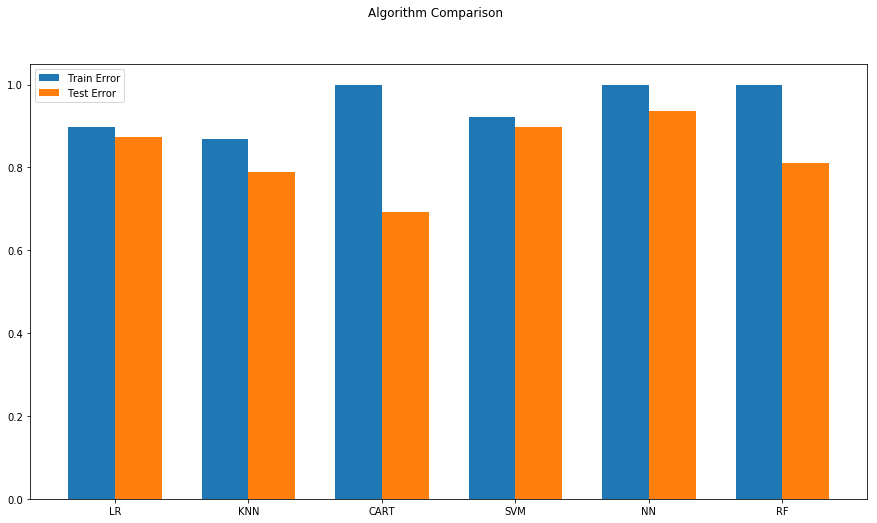

In [29]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [30]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Dividing the data into the training and test set. 

In [31]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier.

In [32]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3977 samples, validate on 2652 samples
Epoch 1/3
3977/3977 [==============================] - ETA: 2:40 - loss: 0.6905 - acc: 0.500 - ETA: 1:25 - loss: 0.6900 - acc: 0.562 - ETA: 1:00 - loss: 0.6886 - acc: 0.593 - ETA: 48s - loss: 0.6914 - acc: 0.562 - ETA: 40s - loss: 0.6912 - acc: 0.56 - ETA: 35s - loss: 0.6897 - acc: 0.56 - ETA: 31s - loss: 0.6884 - acc: 0.56 - ETA: 29s - loss: 0.6876 - acc: 0.56 - ETA: 27s - loss: 0.6859 - acc: 0.57 - ETA: 25s - loss: 0.6852 - acc: 0.56 - ETA: 23s - loss: 0.6814 - acc: 0.57 - ETA: 22s - loss: 0.6855 - acc: 0.56 - ETA: 21s - loss: 0.6846 - acc: 0.56 - ETA: 20s - loss: 0.6804 - acc: 0.57 - ETA: 19s - loss: 0.6776 - acc: 0.57 - ETA: 19s - loss: 0.6726 - acc: 0.58 - ETA: 18s - loss: 0.6688 - acc: 0.59 - ETA: 18s 

3977/3977 [==============================] - ETA: 13s - loss: 0.0111 - acc: 1.00 - ETA: 13s - loss: 0.0073 - acc: 1.00 - ETA: 14s - loss: 0.0069 - acc: 1.00 - ETA: 14s - loss: 0.0124 - acc: 0.99 - ETA: 14s - loss: 0.0136 - acc: 0.99 - ETA: 13s - loss: 0.0150 - acc: 0.99 - ETA: 13s - loss: 0.0141 - acc: 0.99 - ETA: 13s - loss: 0.0133 - acc: 0.99 - ETA: 13s - loss: 0.0123 - acc: 0.99 - ETA: 13s - loss: 0.0127 - acc: 0.99 - ETA: 12s - loss: 0.0202 - acc: 0.99 - ETA: 12s - loss: 0.0196 - acc: 0.99 - ETA: 12s - loss: 0.0202 - acc: 0.99 - ETA: 12s - loss: 0.0223 - acc: 0.99 - ETA: 12s - loss: 0.0213 - acc: 0.99 - ETA: 12s - loss: 0.0228 - acc: 0.99 - ETA: 12s - loss: 0.0218 - acc: 0.99 - ETA: 12s - loss: 0.0207 - acc: 0.99 - ETA: 11s - loss: 0.0211 - acc: 0.99 - ETA: 11s - loss: 0.0201 - acc: 0.99 - ETA: 11s - loss: 0.0193 - acc: 0.99 - ETA: 11s - loss: 0.0222 - acc: 0.99 - ETA: 11s - loss: 0.0228 - acc: 0.98 - ETA: 11s - loss: 0.0219 - acc: 0.98 - ETA: 11s - loss: 0.0213 - acc: 0.99 - ETA: 

In [33]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

2841/2841 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 495us/step


Computing the accuracy and confusion metrics. 

In [34]:
print(train_result_LSTM,test_result_LSTM)

0.9882335193845225 0.9704329461457233


In [35]:
# confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

In [36]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [37]:
names.append("LSTM")

In [39]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [40]:
Y_LSTM = model_LSTM.predict(X_LSTM)

2759/2759 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 471us/step


In [41]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [42]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.10977726955235573


In [43]:
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,201.19,0.2625,0


In [44]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('Data\LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Example of extracting sentiment score for a sentence:

In [45]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [46]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [47]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2759,)

In [48]:
data_df['sentiment_lex'] = vader_sentiments

In [49]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.1047785005800468


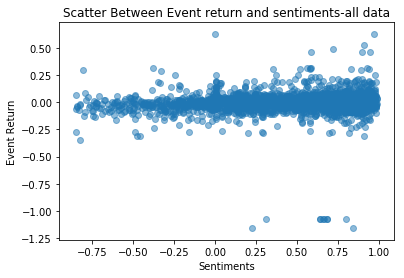

In [50]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

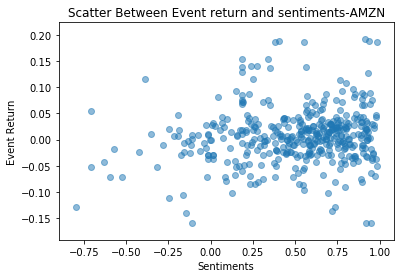

In [51]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [52]:
data_df.to_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|', index=False)

In [53]:
data_df = pd.read_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [54]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,1,0.8575


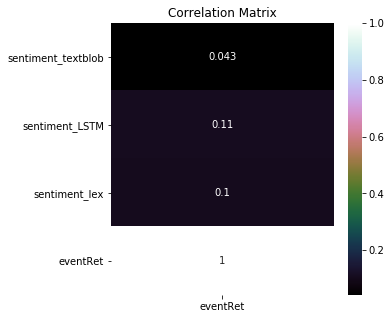

In [55]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. 

In [56]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [57]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(1)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.01983,0.134878,0.138296


In [60]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   



### Function for running the trading strategy

Now, we write a generic function to run the strategy for any stock. We specified the “ticker” stock feeds to be pulled from Yahoo Finance, set an initial amount of $100,000, a fixed size of 100 lots per trade.

In [61]:
def run_strategy(ticker, start, end):
    print(ticker)    
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 70.91
2013-12-16, BUY EXECUTED, Price: 70.99, Cost: 7099.00, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 89.08
2014-09-26, SELL EXECUTED, Price: 89.68, Cost: 7099.00, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 1869.00, NET 1869.00
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 93.27
2014-10-22, BUY EXECUTED, Price: 93.61, Cost: 9361.00, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 118.51
2015-06-12, SELL EXECUTED, Price: 118.14, Cost: 9361.00, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 2453.00, NET 2453.00
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 106.75
2015-09-15, BUY EXECUTED, Price: 107.33, Cost: 10733.00, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CREATE, 104.58
2015-12-15, SELL EXECUTED, Price: 104.08, Cost: 10733.00, Comm

<IPython.core.display.Javascript object>


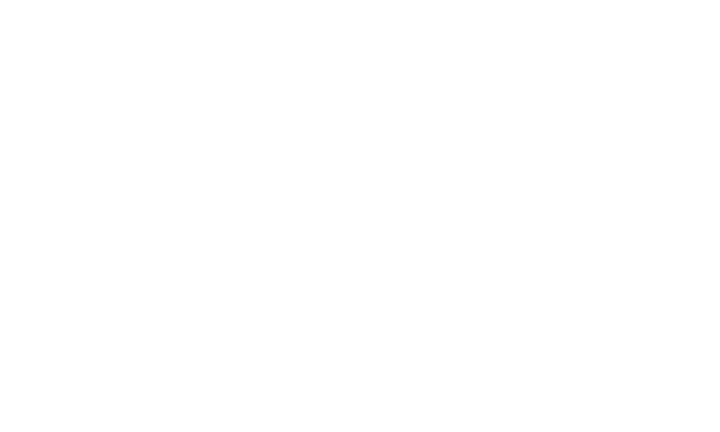

Start Portfolio value: 100000.00
Final Portfolio Value: 103735.00
Profit: 3735.00

MSFT
Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 26.43
2012-03-09, BUY EXECUTED, Price: 26.51, Cost: 2651.00, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 25.77
2012-04-05, SELL EXECUTED, Price: 25.72, Cost: 2651.00, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -79.00, NET -79.00
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 25.52
2012-06-20, BUY EXECUTED, Price: 25.71, Cost: 2571.00, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 23.80
2012-07-13, SELL EXECUTED, Price: 23.90, Cost: 2571.00, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -181.00, NET -181.00
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 24.70
2012-11-02, BUY EXECUTED, Price: 24.76, Cost: 2476.00, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL 

2013-02-21, Previous Sentiment 0.87, New Sentiment 0.04 SELL CREATE, 35.16
2013-02-22, SELL EXECUTED, Price: 35.72, Cost: 3382.00, Comm 0.00
2013-02-22, OPERATION PROFIT, GROSS 190.00, NET 190.00
2013-03-25, Previous Sentiment 0.32, New Sentiment 0.87 BUY CREATE, 37.53
2013-03-26, BUY EXECUTED, Price: 37.98, Cost: 3798.00, Comm 0.00
2013-09-12, Previous Sentiment 0.94, New Sentiment 0.28 SELL CREATE, 164.93
2013-09-13, SELL EXECUTED, Price: 162.77, Cost: 3798.00, Comm 0.00
2013-09-13, OPERATION PROFIT, GROSS 12479.00, NET 12479.00
2014-02-24, Previous Sentiment -0.27, New Sentiment 0.80 BUY CREATE, 217.65
2014-02-25, BUY EXECUTED, Price: 230.00, Cost: 23000.00, Comm 0.00
2014-03-18, Previous Sentiment 0.80, New Sentiment 0.11 SELL CREATE, 240.04
2014-03-19, SELL EXECUTED, Price: 241.39, Cost: 23000.00, Comm 0.00
2014-03-19, OPERATION PROFIT, GROSS 1139.00, NET 1139.00
2014-06-05, Previous Sentiment -0.08, New Sentiment 0.65 BUY CREATE, 206.90
2014-06-06, BUY EXECUTED, Price: 209.75, Co

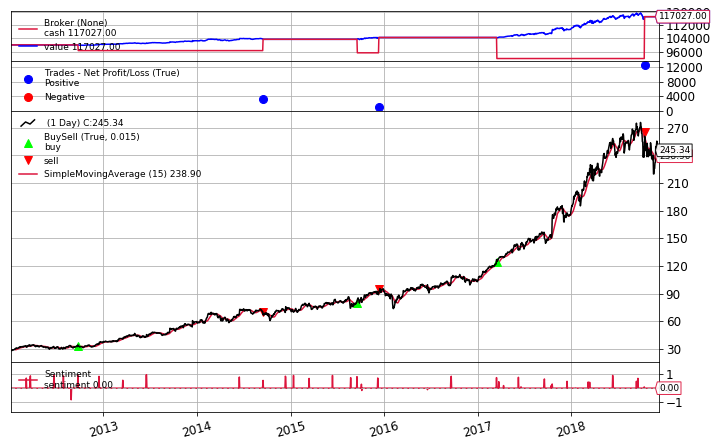

In [65]:
results_tickers = {}
for ticker in tickers:    
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

In [66]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,50.86,21.96,179.03,331.46,38.23,48.78,27.31,28.08,10.32,28.57
StrategyProfit,3735.00,4067.00,75377.00,49719.00,8041.00,1152.00,2014.00,15755.00,25181.00,17027.00


In this step we run the strategy for differnt time periods and look at the results. We first run it for the time period between 2012 and 2014.

AAPL
Starting Portfolio Value: 100000.00
2016-03-15, Previous Sentiment 0.09, New Sentiment 0.66 BUY CREATE, 97.76
2016-03-16, BUY EXECUTED, Price: 97.79, Cost: 9779.00, Comm 0.00
2016-07-26, Previous Sentiment 0.93, New Sentiment 0.14 SELL CREATE, 90.92
2016-07-27, SELL EXECUTED, Price: 98.06, Cost: 9779.00, Comm 0.00
2016-07-27, OPERATION PROFIT, GROSS 27.00, NET 27.00
2016-12-13, Previous Sentiment 0.15, New Sentiment 0.74 BUY CREATE, 109.48
2016-12-14, BUY EXECUTED, Price: 109.34, Cost: 10934.00, Comm 0.00
2017-09-22, Previous Sentiment 0.58, New Sentiment 0.08 SELL CREATE, 146.16
2017-09-25, SELL EXECUTED, Price: 144.33, Cost: 10934.00, Comm 0.00
2017-09-25, OPERATION PROFIT, GROSS 3499.00, NET 3499.00
2017-11-06, Previous Sentiment 0.14, New Sentiment 0.64 BUY CREATE, 167.67
2017-11-07, BUY EXECUTED, Price: 167.35, Cost: 16735.00, Comm 0.00
2017-12-08, Previous Sentiment 0.57, New Sentiment -0.02 SELL CREATE, 163.56
2017-12-11, SELL EXECUTED, Price: 163.40, Cost: 16735.00, Comm 0

<IPython.core.display.Javascript object>


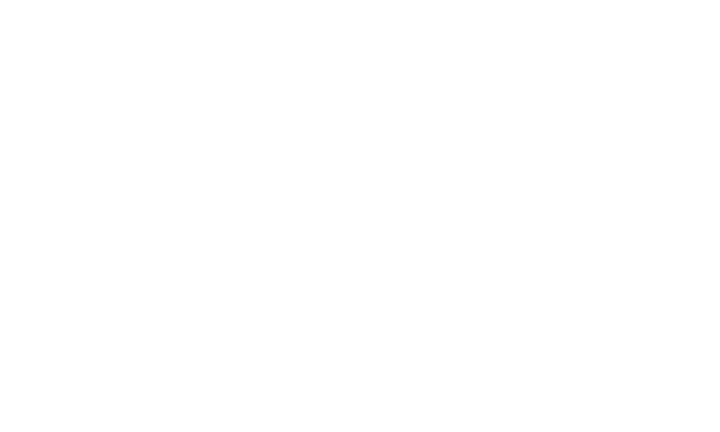

Start Portfolio value: 100000.00
Final Portfolio Value: 99738.00
Profit: -262.00

MSFT
Starting Portfolio Value: 100000.00
2016-01-29, Previous Sentiment 0.01, New Sentiment 0.58 BUY CREATE, 50.52
2016-02-01, BUY EXECUTED, Price: 50.33, Cost: 5033.00, Comm 0.00
2016-02-04, Previous Sentiment 0.58, New Sentiment 0.01 SELL CREATE, 47.69
2016-02-05, SELL EXECUTED, Price: 47.64, Cost: 5033.00, Comm 0.00
2016-02-05, OPERATION PROFIT, GROSS -269.00, NET -269.00
2016-04-21, Previous Sentiment -0.47, New Sentiment 0.90 BUY CREATE, 51.52
2016-04-22, BUY EXECUTED, Price: 47.95, Cost: 4795.00, Comm 0.00
2016-04-28, Previous Sentiment 0.90, New Sentiment 0.01 SELL CREATE, 46.09
2016-04-29, SELL EXECUTED, Price: 45.59, Cost: 4795.00, Comm 0.00
2016-04-29, OPERATION PROFIT, GROSS -236.00, NET -236.00
2017-04-24, Previous Sentiment -0.08, New Sentiment 0.69 BUY CREATE, 64.02
2017-04-25, BUY EXECUTED, Price: 64.37, Cost: 6437.00, Comm 0.00
2017-12-05, Previous Sentiment 0.58, New Sentiment -0.19 SELL 

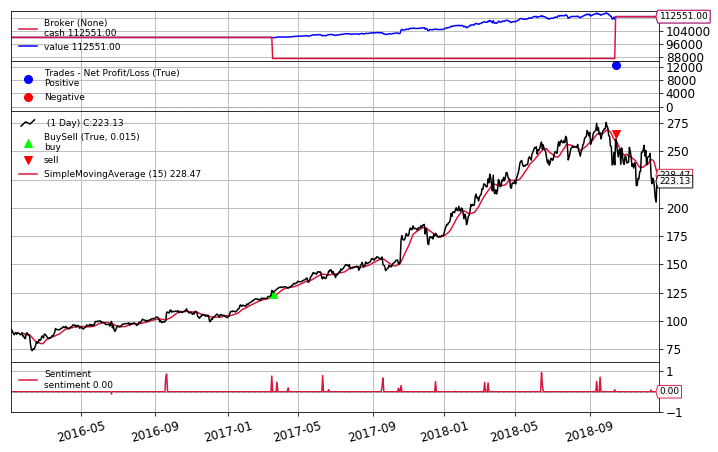

In [69]:
results_tickers = {}
for ticker in tickers: 
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2016-01-01', end = '2018-12-31')

In [70]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,97.95,50.26,636.99,741.84,102.22,54.97,55.84,223.41,109.96,91.97
StrategyProfit,-262.00,3324.00,67454.00,31430.00,648.00,657.00,0.00,10886.00,25020.00,12551.00
